# Text-to-image demo for Frido:
In this demo ipython notebook, you are able to test Frido model and generate images based on the captions in COCO 2014 validation set. We provide two ways to generate image: 
1. random generation: caption is randomly sampled from valid set. 
2. image id specific generation: caption is from the image that user specified.


Note that if you would like to inference the entire validation set, please refer to scripts/sample_diffusion.py for more details. 

---

## Setup datasets and models
All datasets and models will be saved in ./tmp.
You can skip this part if datasets and models have been set up!

In [1]:
# download coco 2014 (josn file only)
! wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

! mkdir tmp
! mv annotations_trainval2014.zip tmp
! unzip tmp/annotations_trainval2014.zip -d tmp

! rm -rf annotations_trainval2014.zip

--2022-08-29 02:48:02--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.1.128
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.1.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  98.2MB/s    in 2.5s    

2022-08-29 02:48:05 (98.2 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

mkdir: cannot create directory ‘tmp’: File exists
Archive:  tmp/annotations_trainval2014.zip
replace tmp/annotations/instances_train2014.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# download azcopy
! wget https://azcopyvnext.azureedge.net/release20220721/azcopy_linux_amd64_10.16.0.tar.gz 
! tar -zxvf azcopy_linux_amd64_10.16.0.tar.gz 
! mv azcopy_linux_amd64_10.16.0/azcopy ./ 
! chmod +x ./azcopy
! rm -rf azcopy_linux_amd64_10.16.0*

# download text-to-image model
! ./azcopy copy "https://acvrpublicycchen.blob.core.windows.net/frido/public_models/t2i/model.ckpt" ./
! mv model.ckpt tmp

--2022-08-29 04:35:05--  https://azcopyvnext.azureedge.net/release20220721/azcopy_linux_amd64_10.16.0.tar.gz
Resolving azcopyvnext.azureedge.net (azcopyvnext.azureedge.net)... 104.97.85.132, 104.97.85.146, 2600:1408:5400:23::b819:7f4b, ...
Connecting to azcopyvnext.azureedge.net (azcopyvnext.azureedge.net)|104.97.85.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12590201 (12M) [application/gzip]
Saving to: ‘azcopy_linux_amd64_10.16.0.tar.gz’

azcopy_linux_amd64_ 100%[===================>]  12.01M  --.-KB/s    in 0.05s   

2022-08-29 04:35:05 (251 MB/s) - ‘azcopy_linux_amd64_10.16.0.tar.gz’ saved [12590201/12590201]

azcopy_linux_amd64_10.16.0/
azcopy_linux_amd64_10.16.0/NOTICE.txt
azcopy_linux_amd64_10.16.0/azcopy
INFO: Scanning...
INFO: Any empty folders will not be processed, because source and/or destination doesn't have full folder support

Job 3e64fb26-9d32-c54b-5ac9-0b8f8792ccf8 has started
Log file is located at: /home/wancyuan/.azcopy/3e64fb26-9d3

---

## Import packages
Change these packages may trigger unexpected error.

In [2]:
import argparse, os, sys, glob, datetime, yaml
import json
import random
import numpy as np
import matplotlib.pyplot as plt 
from omegaconf import OmegaConf
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from frido.util import log_txt_as_img
from frido.models.diffusion.ddim import DDIMSampler

from scripts.sample_diffusion import load_model
from scripts.sample_diffusion import make_convolutional_sample as diffusion_inference

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Demo setting
Inference setting for diffusion model.

In [3]:
# env setting
gpu = True

# demo setting
opt = {
    # You don't need to change this part.
    'ckpt_path': 'tmp/model.ckpt',  # load from logdir or checkpoint in logdir
    'cfg_path': 'configs/t2i/frido_f16f8.yaml',  # path to config.
    'json_path': 'tmp/annotations/captions_val2014.json',  # path to config.
    # You might change these parameters. 
    'n_samples': 4,  # number of samples to draw (This is for random sample mode)
     # user specified image ids (This is for user specified sample mode)
    'image_ids': [525646, 240436, 24195, 329433], #i.g., ['969', '1205', '6870', '407717'], 
    'eta': 1.0, # eta for ddim sampling (0.0 yields deterministic sampling)
    'custom_steps': 200,  # number of steps for ddim and fastdpm sampling
    'use_guidance': True,  # use classifier-free guidance
    'guidance_scale': 1.5  # guidance_scale
}

## Set up model and load pre-trained weights

In [4]:
model_config = OmegaConf.load(opt['cfg_path']) 
ckpt = opt['ckpt_path']
model = load_model(model_config, ckpt, gpu, True)

Loading model from tmp/model.ckpt
FridoDiffusion: Running in eps-prediction mode
DiffusionWrapper has 511.68 M params.
Keeping EMAs of 1059.
Working with z of shape (1, 8, 32, 32) = 8192 dimensions.
Working with z of shape (1, 8, 256, 256) = 524288 dimensions.
Restored from exp/msvqgan/openimage_f16f8/model.ckpt with 0 missing and 49 unexpected keys
Unexpected Keys: ['loss.perceptual_loss.scaling_layer.shift', 'loss.perceptual_loss.scaling_layer.scale', 'loss.perceptual_loss.net.slice1.0.weight', 'loss.perceptual_loss.net.slice1.0.bias', 'loss.perceptual_loss.net.slice1.2.weight', 'loss.perceptual_loss.net.slice1.2.bias', 'loss.perceptual_loss.net.slice2.5.weight', 'loss.perceptual_loss.net.slice2.5.bias', 'loss.perceptual_loss.net.slice2.7.weight', 'loss.perceptual_loss.net.slice2.7.bias', 'loss.perceptual_loss.net.slice3.10.weight', 'loss.perceptual_loss.net.slice3.10.bias', 'loss.perceptual_loss.net.slice3.12.weight', 'loss.perceptual_loss.net.slice3.12.bias', 'loss.perceptual_loss.

## Create input captions from caption.json

In [5]:
# Preprocess caption.json file
with open(opt['json_path']) as f:
    caption_json = json.load(f)
img_id_to_captions = dict()
for ann in caption_json['annotations']:
    try:
        img_id_to_captions[ann['image_id']].append(ann['caption'])
    except:
        img_id_to_captions[ann['image_id']] = ann['caption']

# Get ids for all images 
img_ids = list(img_id_to_captions.keys())

# Create input captions by random sampling or from user given image ids.
selected_id = random.sample(img_ids, k=opt['n_samples']) if len(opt['image_ids']) == 0 else opt['image_ids']
print("Selected image ids: ", selected_id)
input_captions = [img_id_to_captions[ii] for ii in selected_id]
print("Input captions:")
print(input_captions)



Selected image ids:  [525646, 240436, 24195, 329433]
Input captions:
['A pizza pie with lots of green vegetables on it.', 'The river sparkles as it winds it way through the mountain pass.', 'A green bus at a street with a tree by it.', 'Some dishes of food at a restaurant that is well-lit.']


## Create dummy conditions for classifier-free guidance

In [6]:
if opt['use_guidance']:
    xc_tmp = ['' for i in range(len(input_captions))]
    unconditional_conditioning = model.get_learned_conditioning(xc_tmp)
else:
    unconditional_conditioning = None

## Conduct denoising processes to get the generated results.

In [7]:
# Get encoded conditions 
c = model.get_learned_conditioning(input_captions)

# Denoising processes
logs, _ = diffusion_inference(model, batch_size=len(input_captions), cond=c,
                                    custom_steps=opt['custom_steps'],
                                    eta=opt['eta'], unconditional_guidance_scale=opt['guidance_scale'], 
                                    unconditional_conditioning=unconditional_conditioning)

Plotting: Switched to EMA weights
Data shape for DDIM sampling is (4, 8, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [01:03<00:00,  3.13it/s]

Plotting: Restored training weights
Throughput for this batch: 0.04005426329026474


## Visualization all results
- First row => conditions
- Second row => generated results

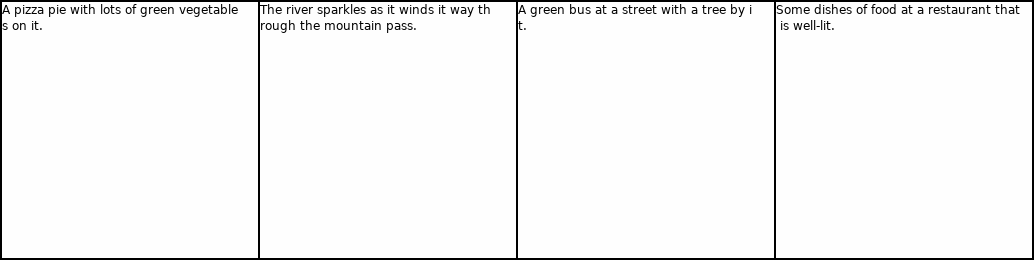

In [8]:
# Visualize conditions
xc = log_txt_as_img((256, 256), input_captions, size=12)

# Plot results
I = torchvision.utils.make_grid(xc, nrow=opt['n_samples'], normalize=True)
I = (I*255).permute(1,2,0).int().numpy()
im = Image.fromarray(np.uint8(I))
im.show()

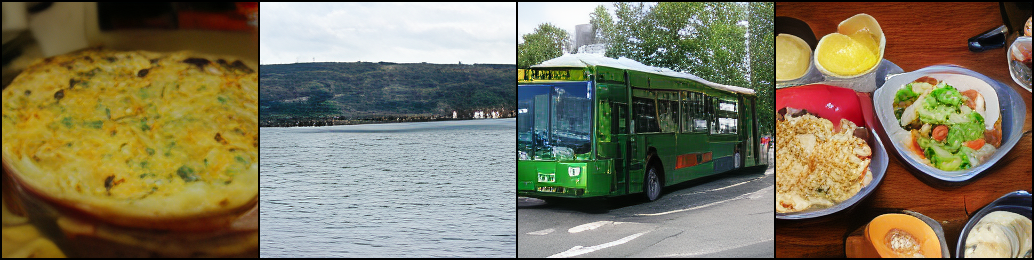

In [10]:
# Visualize samples
out_img = (logs["sample"].cpu() + 1.) / 2.
out_img = torch.clip(out_img, min=0, max=1)

# Plot results
I = torchvision.utils.make_grid(out_img, nrow=opt['n_samples'])
I = (I*255).permute(1,2,0).int().numpy()
im = Image.fromarray(np.uint8(I))
im.show()